Package Installation

In [1]:
!pip install selfcheckgpt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
  Created wheel for selfcheckgpt: filename=selfcheckgpt-0.1.3-py3-none-any.whl size=11593 sha256=91ae60e6a868d50597a2ec0ba6778eae56885d4077f7a083329380ae729717d2
  Stored in directory: /root/.cache/pip/wheels/ba/b3/86/8c89c2bba1d2f2d1b2c982bd0a142831b342459b3d3167101d
Successfully built selfcheckgpt


Import Required Libraries

In [2]:
import torch
import spacy
from selfcheckgpt.modeling_selfcheck import SelfCheckMQAG, SelfCheckBERTScore, SelfCheckNgram

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
selfcheck_ngram = SelfCheckNgram(n=1) # n=1 means Unigram, n=2 means Bigram, etc.

SelfCheck-1gram initialized


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selfcheck_bertscore = SelfCheckBERTScore()

SelfCheck-BERTScore initialized


In [5]:
torch.cuda.is_available()

True

In [6]:
device

device(type='cuda')

In [7]:
selfcheck_mqag = SelfCheckMQAG(device = 'cuda') # set device to 'cuda' if GPU is available

SelfCheck-MQAG initialized to device cuda


In [8]:
nlp = spacy.load('en_core_web_sm')


### **Testing how effectively selfcheckGPT detects**
### We will test for 4 different case and compare the score among them. This is how each test case will look like:
* **Test 1**. Scores for exact same set of samples

* **Test 2**. Scores for set of samples that have same meaning but use of different words or style or sentence length.

* **Test 3**. Scores for set of samples that have different meaning but contain very close wordings

* **Test 4**. Scores for set of samples that are completely different.

NOTE: For the time being I have left N-gram score

In [9]:
test_dict = {
    "Albert Einstein was born on March 14, 1879. He was a great physicist.": [
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "Albert Einstein was born on March 14, 1879. He was a great physicist."
    ],
    "Albert Einstein was born on date March 14, 1879. He was a great physicist.": [
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "The birthdate of Albert Einstein is March 14, 1879. He was an exceptional physicist.",
        "March 14, 1879, marked the arrival of the renowned physicist Albert Einstein."
    ],
    "Earth is the third planet from the sun and is only planet that in our solar system that has life": [
        "Earth is the third planet from the sun and is only planet that in our solar system that has life",
        "Earth does not support life and is the seventh planet from the sun.",
        "Earth is the third sun and our sun supports life, our solar system "
    ],
    " Picasso was a great spanish painter and has contributed a lot in Surrealism": [
        "Picasso was a great pilot and made first flying machine",
        "The Eiffel Tower was built in 1889. It is a famous landmark in Paris.",
        "The Mona Lisa is a masterpiece created by Leonardo da Vinci."
    ]
}

In [10]:
import json
def test(test_dict):
    mqag_scores = []
    bert_scores = []
    ngram_scores = []
    for p, sr in test_dict.items():
#         print(p, sr)
        passage = p
        sentences = [sent.text.strip() for sent in nlp(passage).sents] # spacy sentence tokenization
        samples = sr
        sent_scores_mqag = selfcheck_mqag.predict(
            sentences = sentences,               # list of sentences
            passage = passage,                   # passage (before sentence-split)
            sampled_passages = samples, # list of sampled passages
            num_questions_per_sent = 5,          # number of questions to be drawn
            scoring_method = 'bayes_with_alpha', # options = 'counting', 'bayes', 'bayes_with_alpha'
            beta1 = 0.8, beta2 = 0.8,            # additional params depending on scoring_method
        )
        mqag_scores.append(sent_scores_mqag)
        sent_scores_bertscore = selfcheck_bertscore.predict(
            sentences = sentences,                          # list of sentences
            sampled_passages = samples, # list of sampled passages
        )
        bert_scores.append(sent_scores_bertscore)
        sent_scores_ngram = selfcheck_ngram.predict(
            sentences = sentences,
            passage = passage,
            sampled_passages = samples,
        )
        ngram_scores.append(sent_scores_ngram)
        print(f"{sent_scores_mqag = }    {sent_scores_bertscore = }   {sent_scores_ngram = }")
    scores_data = {
        'mqag_scores': mqag_scores,
        'bert_scores': bert_scores,
        'ngram_scores': ngram_scores
    }

#     with open('scores.json', 'w') as f:
#         json.dump(scores_data, f)
    with open('scores.txt', 'w') as f:
        f.write(f"mqag_scores: {mqag_scores}\n")
        f.write(f"bert_scores: {bert_scores}\n")
        f.write(f"ngram_scores: {ngram_scores}\n")

    print("Scores dumped into scores.json file.")
    return scores_data

# scores_data = test(test_dict)

In [11]:
# Test 1. Scores for exact same set of samples
test_dict1 = {
    "Albert Einstein was born on March 14, 1879. He was a great physicist.": [
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "Albert Einstein was born on March 14, 1879. He was a great physicist."
    ],
    "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.": [
        "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.",
        "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.",
        "The light bulb was invented by Thomas Edison. He has many other inventions under his patent."
    ],
    "The sun is the center of our solar system and other planets revolve around it.": [
        "The sun is the center of our solar system and other planets revolve around it.",
        "The sun is the center of our solar system and other planets revolve around it.",
        "The sun is the center of our solar system and other planets revolve around it."
    ],
    "Water boils at 100 degrees Celsius.": [
        "Water boils at 100 degrees Celsius.",
        "Water boils at 100 degrees Celsius.",
        "Water boils at 100 degrees Celsius."
    ],
    "The Earth is approximately 4.5 billion years old.": [
        "The Earth is approximately 4.5 billion years old.",
        "The Earth is approximately 4.5 billion years old.",
        "The Earth is approximately 4.5 billion years old."
    ]
}
for i in test_dict1.keys():
    print(i)

Albert Einstein was born on March 14, 1879. He was a great physicist.
The light bulb was invented by Thomas Edison. He has many other inventions under his patent.
The sun is the center of our solar system and other planets revolve around it.
Water boils at 100 degrees Celsius.
The Earth is approximately 4.5 billion years old.


In [12]:
test_dict2 = {
    "Albert Einstein was born on March 14, 1879. He was a great physicist.": [
        "Albert Einstein was born on March 14, 1879. He was a great physicist.",
        "The birthdate of Albert Einstein is March 14, 1879. He was an exceptional physicist.",
        "March 14, 1879, marked the arrival of the renowned physicist Albert Einstein."
    ],
    "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.": [
        "Thomas Edison is credited with inventing the light bulb. He held many patents for his other inventions.",
        "The invention of the light bulb is attributed to Thomas Edison, who had several other innovations protected by patents.",
        "Under his patent, Thomas Edison developed the light bulb and many other groundbreaking inventions."
    ],
    "The sun is the center of our solar system and other planets revolve around it.": [
        "Our solar system revolves around the sun, which serves as its central star.",
        "At the centre of our solar system lies the sun, around which all the planets orbit.",
        "The center of our solar system is occupied by the sun, around which everything else revolves."
    ],
    "Water boils at 100 degrees Celsius.": [
        "The boiling point of water is 100 degrees Celsius.",
        "At a temperature of 100 degrees Celsius, water undergoes the process of boiling.",
        "At 100 degrees centigrade water boils"
    ],
    "The Earth is approximately 4.5 billion years old.": [
        "The Earth is estimated to be 4.5 billion years old.",
        "Approximately 4.5 billion years ago, the Earth came into existence.",
        "The age of the Earth is estimated to be about 4.5 billion years."
    ]
}


In [13]:
test_dict3 = {
    "Albert Einstein was born on March 14, 1879. He was a great physicist.": [
        "Albert Einstein was born on March 14, 1779. He was a great pianist.",
        "Albert Einstein died on March 14, 1879. He was a great philosopher.",
        "Albert Einstein was a great mathematician. He was born on September 15, 1879."
    ],
    "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.": [
        "The light bulb was invented by Nicola Tesla. He has many other inventions under his patent.",
        "The light bulb was discovered by Thomas Edison. He also invented time machine.",
        "The sun was discovered by Picasso. He has many patents."
    ],
    "The sun is the center of our solar system and other planets revolve around it.": [
        "The sun is the center of our galaxy and other planets revolve around it.",
        "The sun is a planet in our solar system, and other celestial bodies orbit it.",
        "Other planets are at the center of our solar system, and the sun revolves around them."
    ],
    "Water boils at 100 degrees Celsius.": [
        "Oil boils at 100 degrees Celsius.",
        "Water freezes at 100 degrees Celsius.",
        "The boiling point of water is 50 degrees Celsius."
    ],
    "The Earth is approximately 4.5 billion years old.": [
        "The Earth is approximately 4.5 billion years old.",
        "The Earth is about 100 million years old.",
        "The age of the Earth is estimated to be around 10,000 years."
    ]
}


In [14]:
test_dict4 = {
    "Albert Einstein was born on March 14, 1879. He was a great physicist.": [
        "The sky is blue during a sunny day. Birds fly freely in the air.",
        "Music has the power to evoke strong emotions and create meaningful connections.",
        "The Great Wall of China is an architectural marvel and a symbol of ancient history."
    ],
    "The light bulb was invented by Thomas Edison. He has many other inventions under his patent.": [
        "Roses are beautiful flowers that come in various colors and scents.",
        "The ocean is vast and mysterious, holding countless marine species yet to be discovered.",
        "Sports bring people together, fostering teamwork, competition, and a sense of community."
    ],
    "The sun is the center of our solar system and other planets revolve around it.": [
        "Chocolate is a delightful treat enjoyed by people of all ages.",
        "Traveling allows us to explore new cultures, broaden our perspectives, and create lifelong memories.",
        "Technology has transformed the way we communicate, work, and navigate our daily lives."
    ],
    "Water boils at 100 degrees Celsius.": [
        "The moonlight illuminates the night sky, casting a serene and ethereal glow.",
        "Books have the power to transport us to different worlds, stimulate our imagination, and ignite a love for reading.",
        "Artistic expression comes in many forms, such as painting, sculpture, dance, and poetry."
    ],
    "The Earth is approximately 4.5 billion years old.": [
        "Coffee is a popular beverage enjoyed by millions of people worldwide.",
        "Mountains offer breathtaking views, challenging hikes, and a sense of awe-inspiring beauty.",
        "Science and innovation have led to remarkable advancements in medicine, improving the quality of life."
    ]
}


In [15]:
test_1_scores = test(test_dict1)
test_2_scores = test(test_dict2)
test_3_scores = test(test_dict3)
test_4_scores = test(test_dict4)

sent_scores_mqag = array([0.01571285, 0.36452306])    sent_scores_bertscore = array([0., 0.])   sent_scores_ngram = {'sent_level': {'avg_neg_logprob': [2.633959286127792, 2.541539662053133], 'max_neg_logprob': [2.772588722239781, 2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.599301927099795, 'avg_max_neg_logprob': 2.772588722239781}}
sent_scores_mqag = array([0.01577307, 0.1513078 ])    sent_scores_bertscore = array([0., 0.])   sent_scores_ngram = {'sent_level': {'avg_neg_logprob': [2.813355404500615, 2.813355404500615], 'max_neg_logprob': [2.8903717578961645, 2.8903717578961645]}, 'doc_level': {'avg_neg_logprob': 2.813355404500615, 'avg_max_neg_logprob': 2.8903717578961645}}
sent_scores_mqag = array([0.10914609])    sent_scores_bertscore = array([0.])   sent_scores_ngram = {'sent_level': {'avg_neg_logprob': [2.685945324669788], 'max_neg_logprob': [2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.685945324669788, 'avg_max_neg_logprob': 2.772588722239781}}
sent_scores_m

In [16]:
print(test_1_scores)
print(test_2_scores)
print(test_3_scores)
print(test_4_scores)

{'mqag_scores': [array([0.01571285, 0.36452306]), array([0.01577307, 0.1513078 ]), array([0.10914609]), array([0.01600413]), array([0.026354])], 'bert_scores': [array([0., 0.]), array([0., 0.]), array([0.]), array([5.96046448e-08]), array([0.])], 'ngram_scores': [{'sent_level': {'avg_neg_logprob': [2.633959286127792, 2.541539662053133], 'max_neg_logprob': [2.772588722239781, 2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.599301927099795, 'avg_max_neg_logprob': 2.772588722239781}}, {'sent_level': {'avg_neg_logprob': [2.813355404500615, 2.813355404500615], 'max_neg_logprob': [2.8903717578961645, 2.8903717578961645]}, 'doc_level': {'avg_neg_logprob': 2.813355404500615, 'avg_max_neg_logprob': 2.8903717578961645}}, {'sent_level': {'avg_neg_logprob': [2.685945324669788], 'max_neg_logprob': [2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.685945324669788, 'avg_max_neg_logprob': 2.772588722239781}}, {'sent_level': {'avg_neg_logprob': [1.9459101490553132], 'max_neg_logprob': [1

In [17]:
# test1 visual
print(test_1_scores)


{'mqag_scores': [array([0.01571285, 0.36452306]), array([0.01577307, 0.1513078 ]), array([0.10914609]), array([0.01600413]), array([0.026354])], 'bert_scores': [array([0., 0.]), array([0., 0.]), array([0.]), array([5.96046448e-08]), array([0.])], 'ngram_scores': [{'sent_level': {'avg_neg_logprob': [2.633959286127792, 2.541539662053133], 'max_neg_logprob': [2.772588722239781, 2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.599301927099795, 'avg_max_neg_logprob': 2.772588722239781}}, {'sent_level': {'avg_neg_logprob': [2.813355404500615, 2.813355404500615], 'max_neg_logprob': [2.8903717578961645, 2.8903717578961645]}, 'doc_level': {'avg_neg_logprob': 2.813355404500615, 'avg_max_neg_logprob': 2.8903717578961645}}, {'sent_level': {'avg_neg_logprob': [2.685945324669788], 'max_neg_logprob': [2.772588722239781]}, 'doc_level': {'avg_neg_logprob': 2.685945324669788, 'avg_max_neg_logprob': 2.772588722239781}}, {'sent_level': {'avg_neg_logprob': [1.9459101490553132], 'max_neg_logprob': [1

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_score(scores_dict):
    mqag_scores = scores_dict['mqag_scores']
    bert_scores = scores_dict['bert_scores']
    ngram_scores = scores_dict['ngram_scores']

    # Take the average if an element in mqag_scores is a list
    mqag_scores = [np.array(np.mean(score)) if len(score)>1 else score for score in mqag_scores]
    bert_scores = [np.array(np.mean(score)) if len(score)>1 else score for score in bert_scores]
    ngram_scores = [score["sent_level"]["avg_neg_logprob"] for score in ngram_scores]
    ngram_scores = [np.array(np.mean(score)) if len(score) > 1 else score for score in ngram_scores]

#     Plotting MQAG scores and BERT scores
    plt.figure(figsize=(8, 5))
    x = np.arange(len(mqag_scores))
    plt.bar(x, mqag_scores, width=0.2, label='MQAG Scores')
    plt.bar(x + 0.2, bert_scores, width=0.2, label="BERT Scores")
    plt.xlabel('Index')
    plt.ylabel('Score')
    plt.title('MQAG Scores and BERT Scores')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    x = np.arange(len(mqag_scores))
    plt.bar(x, ngram_scores, width=0.2, label='Ngram Scores')
    plt.xlabel('Index')
    plt.ylabel('Score')
    plt.title('Ngram scores')
    plt.legend()
    plt.show()


# Main results

/opt/conda/lib/python3.10/site-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


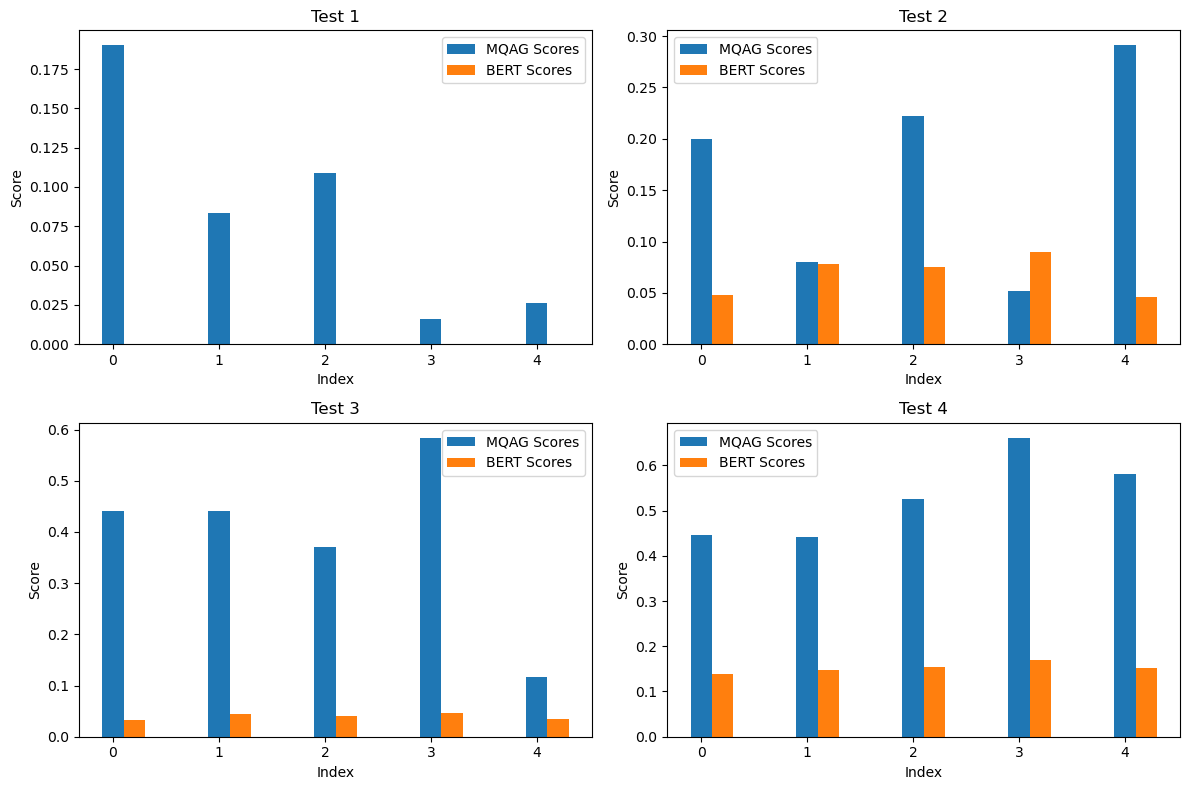

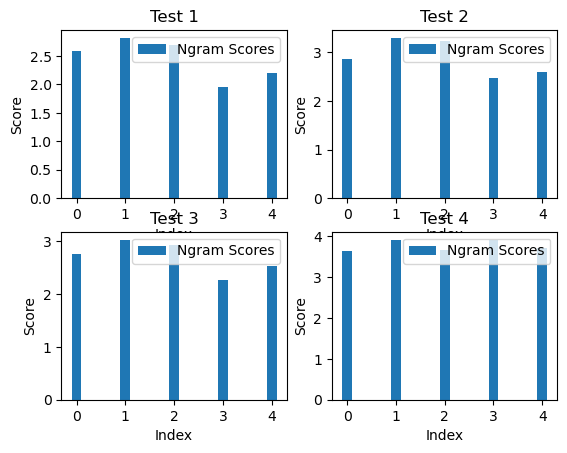

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_scores(scores_list):
    num_tests = len(scores_list)

    plt.figure(figsize=(12, 8))

    for i, scores_dict in enumerate(scores_list):
        mqag_scores = scores_dict['mqag_scores']
        bert_scores = scores_dict['bert_scores']


        # Take the average if an element in mqag_scores is a list
        mqag_scores = [np.array(np.mean(score)) if len(score) > 1 else score for score in mqag_scores]
        bert_scores = [np.array(np.mean(score)) if len(score) > 1 else score for score in bert_scores]
        # Subplot position
        plt.subplot(2, 2, i + 1)

        # Generate x-axis positions for columns
        x = np.arange(len(mqag_scores))

        # Plotting MQAG scores and BERT scores as columns
        plt.bar(x, mqag_scores, width=0.2, label='MQAG Scores')
        plt.bar(x + 0.2, bert_scores, width=0.2, label="BERT Scores")
        plt.xlabel('Index')
        plt.ylabel('Score')
        plt.title(f'Test {i + 1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    for i, scores_dict in enumerate(scores_list):
        ngram_scores = scores_dict['ngram_scores']


        # Take the average if an element in mqag_scores is a list
        ngram_scores = [score["sent_level"]["avg_neg_logprob"] for score in ngram_scores]
        ngram_scores = [np.array(np.mean(score)) if len(score) > 1 else score for score in ngram_scores]

        # Subplot position
        plt.subplot(2, 2, i + 1)

        # Generate x-axis positions for columns
        x = np.arange(len(ngram_scores))

        # Plotting ngram scores as columns
        plt.bar(x , ngram_scores, width=0.2, label="Ngram Scores")
        plt.xlabel('Index')
        plt.ylabel('Score')
        plt.title(f'Test {i + 1}')
        plt.legend()



plot_scores([test_1_scores,
            test_2_scores,
            test_3_scores,
            test_4_scores])

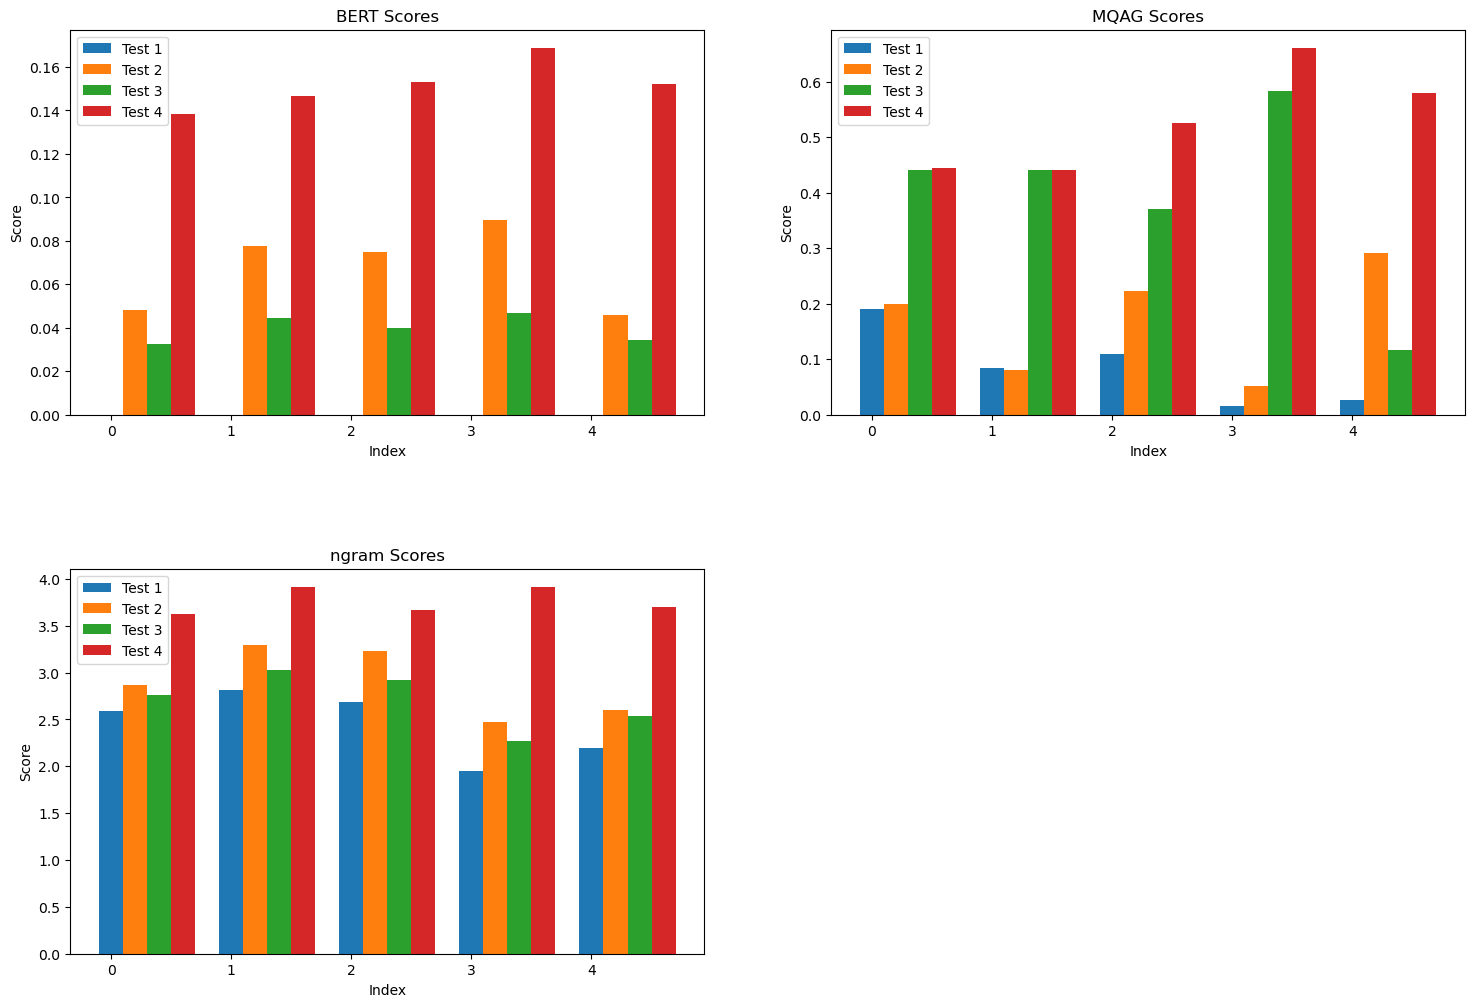

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scores2(scores_list):
    num_tests = len(scores_list)

    plt.figure(figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4)

    # Create separate subplots for each score type
    score_types = ['BERT', 'MQAG', 'ngram']

    for i, score_type in enumerate(score_types):
        plt.subplot(2, 2, i + 1)
        plt.title(f'{score_type} Scores')

        for j, scores_dict in enumerate(scores_list):
            scores = scores_dict[f'{score_type.lower()}_scores']

            # Take the average if an element in scores is a list
            if score_type == 'ngram':
              scores = [score["sent_level"]["avg_neg_logprob"] for score in scores]
            scores = [np.array(np.mean(score)) if len(score) > 1 else score for score in scores]

            # Generate x-axis positions for columns
            x = np.arange(len(scores))

            # Plot scores as columns
            plt.bar(x + j * 0.2, scores, width=0.2, label=f'Test {j + 1}')

        plt.xlabel('Index')
        plt.ylabel('Score')
        plt.legend()

    plt.show()


plot_scores2([test_1_scores,
            test_2_scores,
            test_3_scores,
            test_4_scores])


Points

* So high bert and mqag score (close to 1.0) is supposed to be hallucinated

* Type1 and type2 are not hallucinated sentence and Type3 and Type4 are hallucinated that what graphs show

* I have not used ngram score rn.

sent_scores_mqag = array([0.05277975, 0.20375074, 0.35098561, 0.33771064, 0.29516495])    sent_scores_bertscore = array([0.02527738, 0.03858576, 0.09815411, 0.05635834, 0.08287221])   sent_scores_ngram = {'sent_level': {'avg_neg_logprob': [4.402500011361693, 4.519385497317295, 4.741060803059054, 4.518769885133657, 4.361743569747539], 'max_neg_logprob': [5.526780079339846, 5.932245187448011, 5.932245187448011, 5.932245187448011, 5.932245187448011]}, 'doc_level': {'avg_neg_logprob': 4.497654529599371, 'avg_max_neg_logprob': 5.851152165826378}}
Scores dumped into scores.json file.


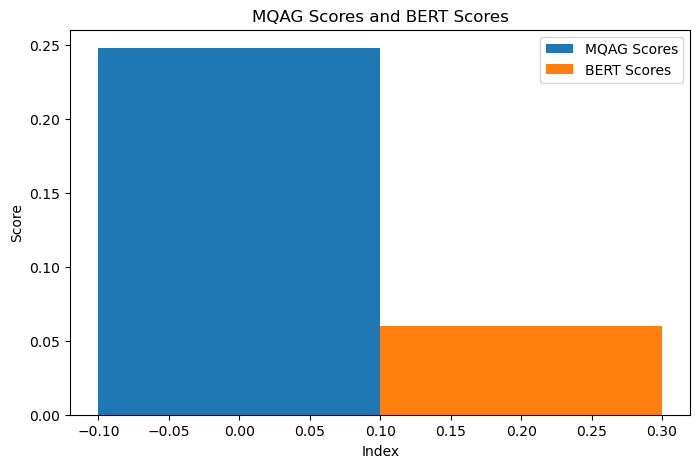

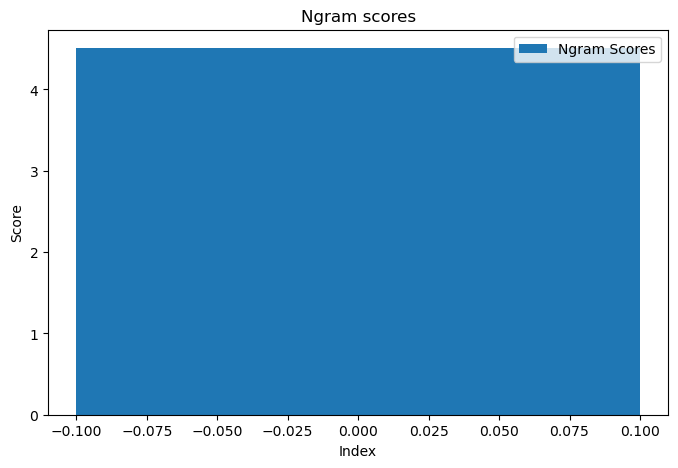

In [21]:
test_dict = {
    """Michael Alan Weiner (born March 31, 1942), better known by his professional name Michael Savage, is an American radio host, author, activist, nutritionist, and conservative political commentator. He is the host of The Savage Nation, a nationally syndicated talk show that aired on Talk Radio Network across the United States until 2012, and in 2009 was the second most listened-to radio talk show in the country with an audience of over 20 million listeners on 400 stations across the United States. Since October 23, 2012, Michael Savage has been syndicated by Cumulus Media Networks. He holds master's degrees from the University of Hawaii in medical botany and medical anthropology, and a Ph.D. from the University of California, Berkeley in nutritional ethnomedicine. As Michael Weiner, he has written books on nutrition, herbal medicine, and homeopathy.""".replace("\n", " ").strip(): [
        """Michael Alan Weiner (born March 31, 1942), better known by his professional name Michael Savage, is an American radio host, author, and political commentator. He is the host of The Savage Nation, a nationally syndicated talk show broadcast on Talk Radio Network across the United States, and on Comet in Canada. He holds master's degrees from the University of Hawaii in medical botany and medical anthropology, and a Ph.D. from the University of California, Berkeley in epidemiology and nutrition sciences. Savage has summarized his political philosophy in three words: borders, language, and culture. He has characterized his views as conservative nationalism, while critics have characterized them as fascism. He is a fierce critic of liberalism, and the War on Drugs. He believes that political correctness has 'ruined the United States' and that the American government has spent too much money on social programs throughout its history.""".replace("\n", " ").strip(),
        """Michael A. Savage (born Michael Alan Weiner; March 31, 1942) is an American radio host, author, activist, nutritionist, and conservative political commentator. He is the host of The Savage Nation, a nationally syndicated talk show that aired on Talk Radio Network across the United States until 2012. The Savage Nation has a combined audience of over 20 million listeners on 400 stations across the United States and is one of the top-rated shows in the country. He is also the host of The Michael Savage Show, a daily podcast and webcast heard around the world. He has been called 'the godfather of Trumpmania'.Savage has written more than 25 books and is an outspoken supporter of traditional American values and break-down of the culture of political correctness. He advocates an 'America first' foreign policy and rigorous opposition to illegal immigration. For his social and political views, Savage has been described as a conservative and a right-wing populist. He has campaigned for numerous political causes, including opposition to same-sex marriage and the legalization of marijuana.""".replace("\n", " ").strip(),
        """Michael Alan Weiner (born March 31, 1942),[2] better known by his professional name Michael Savage, is an American radio host, author, activist, nutritionist, and conservative political commentator. He is the host of The Savage Nation, a nationally syndicated talk show that aired on Talk Radio Network across the United States until 2012, and in 2009 was the second most listened-to radio talk show in the country with an audience of over 20 million listeners on 400 stations across the United States. Since October 23, 2012, Michael Savage has been syndicated by Cumulus Media Networks. He holds master's degrees from the University of Hawaii in medical botany and medical anthropology, and a Ph.D. from the University of California, Berkeley in nutritional ethnomedicine. As Michael Weiner, he has written books on nutrition, herbal medicine, and homeopathy. Savage has summarized his political philosophy in three words: borders, language, and culture. He believes that the United States should end foreign aid, impose much stricter immigration laws, deport illegal immigrants, and put an end to birthright citizenship. Savage has characterized his views as conservative nationalism, free""".replace("\n", " ").strip()
    ]
}


test_score_here = test(test_dict)
plot_score(test_score_here)